In [19]:
from IPython.display import display, Markdown

toc = """
# Table of Contents
1. [Data Preparation](#data-preparation)
2. [DBSCAN Clustering](#dbscan-clustering)
3. [Hyperparameter Tuning for DBSCAN](#hyperparameter-tuning-for-DBSCAN)
4. [Results and Visualizations](#results-and-visualizations)
"""

display(Markdown(toc))


# Table of Contents
1. [Data Preparation](#data-preparation)
2. [DBSCAN Clustering](#dbscan-clustering)
3. [Hyperparameter Tuning for DBSCAN](#hyperparameter-tuning-for-DBSCAN)
4. [Results and Visualizations](#results-and-visualizations)


## Data Preparation
### Step 1: Load Data

In [20]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.metrics import davies_bouldin_score
import matplotlib.pyplot as plt
import seaborn as sns

customers = pd.read_csv('Dataset/Customers.csv')
transactions = pd.read_csv('Dataset/Transactions.csv')

### Step 2: Feature Engineering

In [21]:
# Feature engineering to calculate RFM metrics
transactions['TransactionDate'] = pd.to_datetime(transactions['TransactionDate'])
# Calculate recency
last_transaction = transactions.groupby('CustomerID')['TransactionDate'].max().reset_index()
last_transaction['Recency'] = (transactions['TransactionDate'].max() - last_transaction['TransactionDate']).dt.days
# Frequency
frequency = transactions.groupby('CustomerID')['TransactionID'].count().reset_index()
frequency.rename(columns={'TransactionID': 'Frequency'}, inplace=True)
# Monetary
monetary = transactions.groupby('CustomerID')['TotalValue'].sum().reset_index()
monetary.rename(columns={'TotalValue': 'Monetary'}, inplace=True)
# Merging RFM and Customer Data
rfm = last_transaction[['CustomerID', 'Recency']].merge(frequency, on='CustomerID').merge(monetary, on='CustomerID')
# Scaling
scaler = StandardScaler()
rfm_scaled = scaler.fit_transform(rfm[['Recency', 'Frequency', 'Monetary']])

## DBSCAN Clustering

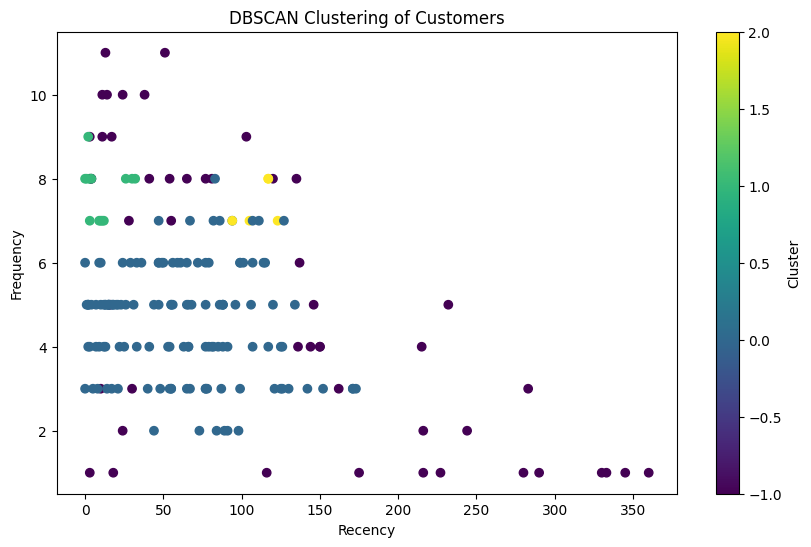

In [ ]:
from sklearn.cluster import DBSCAN
import matplotlib.pyplot as plt

# Apply DBSCAN
dbscan = DBSCAN(eps=0.5, min_samples=5)
rfm['Cluster'] = dbscan.fit_predict(rfm_scaled)

# Visualize the results
plt.figure(figsize=(10, 6))
plt.scatter(rfm['Recency'], rfm['Frequency'], c=rfm['Cluster'], cmap='viridis')
plt.title('DBSCAN Clustering of Customers')
plt.xlabel('Recency')
plt.ylabel('Frequency')
plt.colorbar(label='Cluster')
plt.show()


In [23]:
from sklearn.metrics import silhouette_score

silhouette_avg = silhouette_score(rfm_scaled, rfm['Cluster'])
print(f'Silhouette Score: {silhouette_avg}')


Silhouette Score: 0.1506412045919538


In [24]:
from sklearn.metrics import davies_bouldin_score

db_index = davies_bouldin_score(rfm_scaled, rfm['Cluster'])
print(f'Davies-Bouldin Index: {db_index}')


Davies-Bouldin Index: 2.5241628195788786


## Hyperparameter Tuning for DBSCAN

In [25]:
# Create a range of values for eps and min_samples to search
eps_values = np.linspace(0.1, 1.5, 15) 
min_samples_values = range(3, 11) 

best_silhouette = -1
best_db_index = np.inf
best_eps = 0
best_min_samples = 0
best_labels = None

# Perform grid search for DBSCAN hyperparameters
for eps in eps_values:
    for min_samples in min_samples_values:
        # Apply DBSCAN with current parameters
        dbscan = DBSCAN(eps=eps, min_samples=min_samples)
        labels = dbscan.fit_predict(rfm_scaled)
        if len(np.unique(labels)) > 1:
            silhouette_avg = silhouette_score(rfm_scaled, labels)
            db_index = davies_bouldin_score(rfm_scaled, labels)
            
            # Track the best model
            if silhouette_avg > best_silhouette:
                best_silhouette = silhouette_avg
                best_db_index = db_index
                best_eps = eps
                best_min_samples = min_samples
                best_labels = labels


## Results and Visualizations

In [26]:
# Output the best model's performance
print(f"Best DBSCAN Parameters: eps={best_eps}, min_samples={best_min_samples}")
print(f"Best Silhouette Score: {best_silhouette}")
print(f"Best Davies-Bouldin Index: {best_db_index}")

Best DBSCAN Parameters: eps=1.2, min_samples=3
Best Silhouette Score: 0.5114374744524408
Best Davies-Bouldin Index: 0.32058980906878926


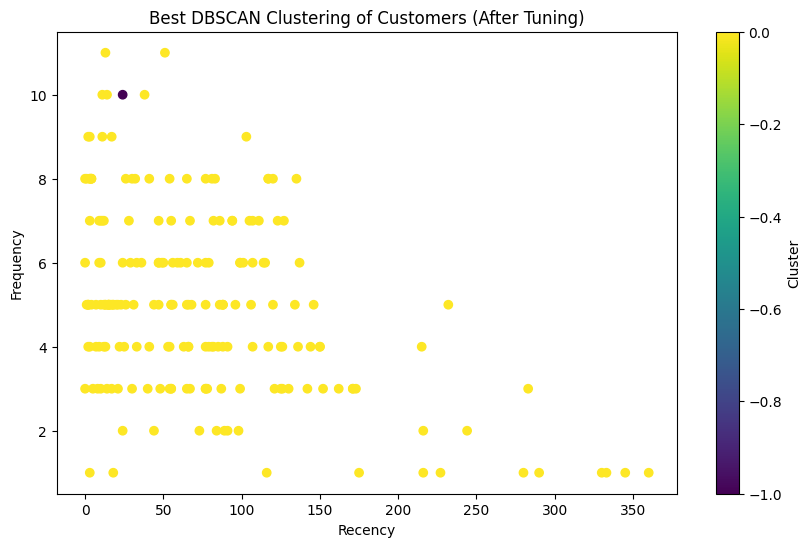

In [27]:
# Visualize the best clustering result
plt.figure(figsize=(10, 6))
plt.scatter(rfm['Recency'], rfm['Frequency'], c=best_labels, cmap='viridis')
plt.title('Best DBSCAN Clustering of Customers (After Tuning)')
plt.xlabel('Recency')
plt.ylabel('Frequency')
plt.colorbar(label='Cluster')
plt.show()
